# Problem
- Use BERT and XLNet to classify sentiment from vietnamese students reviews.

## Download dataset
Vietnamese Students' Feedback Corpus (UIT-VSFC) is the resource consists of over 16,000 sentences which are human-annotated with two different tasks: sentiment-based and topic-based classifications.

[1] Kiet Van Nguyen, Vu Duc Nguyen, Phu Xuan-Vinh Nguyen, Tham Thi-Hong Truong, Ngan Luu-Thuy Nguyen, UIT-VSFC: Vietnamese Students' Feedback Corpus for Sentiment Analysis,  2018 10th International Conference on Knowledge and Systems Engineering (KSE 2018), November 1-3, 2018, Ho Chi Minh City, Vietnam

In [1]:
!pip install datasets

In [2]:
from datasets import load_dataset

dataset = load_dataset("uitnlp/vietnamese_students_feedback")

## Train set exploration

In [3]:
train_set = dataset['train']
train_set

Dataset({
    features: ['sentence', 'sentiment', 'topic'],
    num_rows: 11426
})

In [4]:
train_set[0]

{'sentence': 'slide giáo trình đầy đủ .', 'sentiment': 2, 'topic': 1}

In [5]:
len(train_set)

11426

In [6]:
# Unique labels
set(train_set['sentiment'])

{0, 1, 2}

In [7]:
# Unique labels
set(train_set['topic'])

{0, 1, 2, 3}

In [8]:
# Giảm số lượng mẫu dữ liệu
train_set = train_set.select(range(5000))

## Test set exploration

In [9]:
test_set = dataset['test']
test_set

Dataset({
    features: ['sentence', 'sentiment', 'topic'],
    num_rows: 3166
})

In [10]:
test_set[0]

{'sentence': 'nói tiếng anh lưu loát .', 'sentiment': 2, 'topic': 0}

In [11]:
len(test_set)

3166

# Valid set exploration

In [12]:
valid_set = dataset['validation']

In [13]:
valid_set[0]

{'sentence': 'giáo trình chưa cụ thể .', 'sentiment': 0, 'topic': 1}

In [14]:
len(valid_set)

1583

# Question:

For both BERT - XLNet and vietnamese texts (this homework) and english texts (previous homework):
- Are there any differences in the evaluating performance in applying those 2 models for 2 datasets, i.e., vietnamese and english ? Analyze and visualize your results to prove your conclusion.
- How to improve the weaker approaches ?

## Valid set

# Tokenize data

In [15]:
# Tokenize dữ liệu
from transformers import BertTokenizerFast
from transformers import XLNetTokenizerFast

class Tokenizer:
    def __init__(self, model_name, max_length=128):
        if 'bert' in model_name:
            self.tokenizer = BertTokenizerFast.from_pretrained(model_name)
        elif 'xlnet' in model_name:
            self.tokenizer = XLNetTokenizerFast.from_pretrained(model_name)
        self.max_length = max_length

    def tokenize_function(self, examples):
        texts = examples.get('sentence', examples.get('text'))
        return self.tokenizer(
            texts,
            truncation=True,
            padding="max_length",
            max_length=self.max_length
        )

In [16]:
tokenizer = Tokenizer('bert-base-uncased')

train_set = train_set.map(tokenizer.tokenize_function, batched=True).rename_column("sentiment", "labels")
valid_set = valid_set.map(tokenizer.tokenize_function, batched=True).rename_column("sentiment", "labels")
test_set = test_set.map(tokenizer.tokenize_function, batched=True).rename_column("sentiment", "labels")

train_set.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
valid_set.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
test_set.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1583 [00:00<?, ? examples/s]

Map:   0%|          | 0/3166 [00:00<?, ? examples/s]

# Create Dataloader

In [17]:
# Create a DataLoader
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_set, batch_size=16, num_workers=8, shuffle=True)
valid_dataloader = DataLoader(valid_set, batch_size=16, num_workers=8, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=16, num_workers=8, shuffle=True)

# Build and load model

In [18]:
# Build Model
from torch.optim import AdamW
from transformers import BertForSequenceClassification, XLNetForSequenceClassification

class ModelBuilder:
    def __init__(self, model_name, num_labels=3):
        if 'bert' in model_name:
            self.model_class = BertForSequenceClassification
        elif 'xlnet' in model_name:
            self.model_class = XLNetForSequenceClassification
        self.model_name = model_name
        self.num_labels = num_labels
        self.model = None

    def build_model(self):
        self.model = self.model_class.from_pretrained(self.model_name, num_labels=self.num_labels)
        return self.model
    
    def optimizer(self, learning_rate=5e-5):
        return AdamW(self.model.parameters(), lr=learning_rate)

In [19]:
# Load Model
bert_model_builder = ModelBuilder('bert-base-uncased', num_labels=3)
bert_model = bert_model_builder.build_model()
bert_optimizer = bert_model_builder.optimizer()

xlnet_model_builder = ModelBuilder('xlnet-base-cased', num_labels=3)
xlnet_model = xlnet_model_builder.build_model()
xlnet_optimizer = xlnet_model_builder.optimizer()

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Train model

In [ ]:
# Train the model
from transformers import Trainer, TrainingArguments
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

class TrainerBuilder:
    def __init__(self, model, train_dataloader, valid_dataloader, optimizer, epochs=1):
        self.model = model
        self.train_dataset = train_dataloader.dataset
        self.valid_dataset = valid_dataloader.dataset
        self.epochs = epochs
        self.optimizer = optimizer

    def train(self):
        # Set up hyperparameters for training procedure
        training_args = TrainingArguments(
            output_dir="./results",
            logging_strategy="no",
            per_device_train_batch_size=8,
            num_train_epochs=self.epochs,
            weight_decay=0.01,
            logging_dir="./logs",
            evaluation_strategy="no",
            save_strategy="no"
        )

        trainer = Trainer(
            model=self.model,
            args=training_args,
            train_dataset=self.train_dataset,
            eval_dataset=self.valid_dataset,
            optimizers=(self.optimizer, None)
        )

        trainer.train()
        return trainer

# Evaluate model

In [ ]:
# Evaluate the model
class Evaluator:
    def __init__(self, model, eval_dataloader, optimizer):
        self.model = model
        self.eval_dataset = eval_dataloader.dataset
        self.optimizer = optimizer

    def evaluate(self):
        eval_args = TrainingArguments(
            output_dir="./results_eval",
            per_device_eval_batch_size=8,
            evaluation_strategy="epoch",
            save_strategy="no",
            logging_dir="./logs_eval"
        )

        trainer = Trainer(
            model=self.model,
            args=eval_args,
            eval_dataset=self.eval_dataset,
            compute_metrics=lambda p: {
                'accuracy': accuracy_score(np.argmax(p.predictions, axis=1), p.label_ids),
                'f1': precision_recall_fscore_support(p.label_ids, np.argmax(p.predictions, axis=1), average='weighted')[2],
                'precision': precision_recall_fscore_support(p.label_ids, np.argmax(p.predictions, axis=1), average='weighted')[0],
                'recall': precision_recall_fscore_support(p.label_ids, np.argmax(p.predictions, axis=1), average='weighted')[1]
            },
            optimizers=(self.optimizer, None)
        )

        metrics = trainer.evaluate()
        return metrics

# Vietnamese Text

## BERT model

In [22]:
# Train
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model.to(device)
trainer_builder = TrainerBuilder(bert_model, train_dataloader, valid_dataloader, bert_optimizer)
trainer = trainer_builder.train()

  0%|          | 0/625 [00:00<?, ?it/s]

{'loss': 0.4919, 'grad_norm': 6.155267238616943, 'learning_rate': 0.0, 'epoch': 1.0}


  0%|          | 0/198 [00:00<?, ?it/s]

{'eval_loss': 0.3852715790271759, 'eval_runtime': 14.8424, 'eval_samples_per_second': 106.654, 'eval_steps_per_second': 13.34, 'epoch': 1.0}
{'train_runtime': 172.6604, 'train_samples_per_second': 28.959, 'train_steps_per_second': 3.62, 'train_loss': 0.4919158203125, 'epoch': 1.0}


In [23]:
# Evaluate
evaluator = Evaluator(bert_model, test_dataloader, bert_optimizer)
print(evaluator.evaluate())

  0%|          | 0/396 [00:00<?, ?it/s]

{'eval_loss': 0.454088419675827, 'eval_accuracy': 0.8600758054327227, 'eval_f1': 0.8367833204480498, 'eval_precision': 0.8157707759362268, 'eval_recall': 0.8600758054327227, 'eval_runtime': 29.4227, 'eval_samples_per_second': 107.604, 'eval_steps_per_second': 13.459}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [24]:
metrics = evaluator.evaluate()
vn_bert_accuracy = metrics.get('eval_accuracy')
vn_bert_f1 = metrics.get('eval_f1')
vn_bert_precision = metrics.get('eval_precision')
vn_bert_recall = metrics.get('eval_recall')

  0%|          | 0/396 [00:00<?, ?it/s]

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

## XLNet model

In [25]:
# Train
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
xlnet_model.to(device)
trainer_builder = TrainerBuilder(xlnet_model, train_dataloader, valid_dataloader, xlnet_optimizer)
trainer = trainer_builder.train()

  0%|          | 0/625 [00:00<?, ?it/s]

{'loss': 0.5439, 'grad_norm': 5.512360095977783, 'learning_rate': 0.0, 'epoch': 1.0}


  0%|          | 0/198 [00:00<?, ?it/s]

{'eval_loss': 0.4647887051105499, 'eval_runtime': 19.4671, 'eval_samples_per_second': 81.317, 'eval_steps_per_second': 10.171, 'epoch': 1.0}
{'train_runtime': 805.3588, 'train_samples_per_second': 6.208, 'train_steps_per_second': 0.776, 'train_loss': 0.54392158203125, 'epoch': 1.0}


In [26]:
# Evaluate
evaluator = Evaluator(xlnet_model, test_dataloader, xlnet_optimizer)
print(evaluator.evaluate())

  0%|          | 0/396 [00:00<?, ?it/s]

{'eval_loss': 0.5061424970626831, 'eval_accuracy': 0.844914718888187, 'eval_f1': 0.8222744210534896, 'eval_precision': 0.8026797955607052, 'eval_recall': 0.844914718888187, 'eval_runtime': 42.1931, 'eval_samples_per_second': 75.036, 'eval_steps_per_second': 9.385}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [27]:
metrics = evaluator.evaluate()
vn_xlnet_accuracy = metrics.get('eval_accuracy')
vn_xlnet_f1 = metrics.get('eval_f1')
vn_xlnet_precision = metrics.get('eval_precision')
vn_xlnet_recall = metrics.get('eval_recall')

  0%|          | 0/396 [00:00<?, ?it/s]

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

# English Text

In [28]:
from datasets import load_dataset

imdb_dataset = load_dataset("imdb")

In [31]:
# Prepare IMDB dataset
imdb_train_set = imdb_dataset["train"].select(range(10000))
imdb_test_set = imdb_dataset["test"].select(range(5000))
imdb_valid_set = imdb_dataset["train"].select(range(20000, 25000))

In [32]:
# Tokenize the IMDB dataset
tokenizer = Tokenizer('bert-base-uncased')
imdb_train_set = imdb_train_set.map(tokenizer.tokenize_function, batched=True).rename_column("label", "labels")
imdb_valid_set = imdb_valid_set.map(tokenizer.tokenize_function, batched=True).rename_column("label", "labels")
imdb_test_set = imdb_test_set.map(tokenizer.tokenize_function, batched=True).rename_column("label", "labels")
imdb_train_set.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
imdb_valid_set.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
imdb_test_set.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

## Bert Model

In [33]:
from torch.utils.data import DataLoader

imdb_train_dataloader = DataLoader(imdb_train_set, batch_size=16, num_workers=8, shuffle=True)
imdb_valid_dataloader = DataLoader(imdb_valid_set, batch_size=16, num_workers=8, shuffle=True)
imdb_test_dataloader = DataLoader(imdb_test_set, batch_size=16, num_workers=8, shuffle=True)
# Train on IMDB dataset
imdb_trainer_builder = TrainerBuilder(bert_model, imdb_train_dataloader, imdb_valid_dataloader, bert_optimizer)
imdb_trainer = imdb_trainer_builder.train()
# Evaluate on IMDB dataset
imdb_evaluator = Evaluator(bert_model, imdb_test_dataloader, bert_optimizer)
print(imdb_evaluator.evaluate())

  0%|          | 0/1250 [00:00<?, ?it/s]

{'loss': 0.0007, 'grad_norm': 0.0014088175958022475, 'learning_rate': 0.0, 'epoch': 1.0}


  0%|          | 0/625 [00:00<?, ?it/s]

{'eval_loss': 10.743939399719238, 'eval_runtime': 47.6745, 'eval_samples_per_second': 104.878, 'eval_steps_per_second': 13.11, 'epoch': 1.0}
{'train_runtime': 858.3427, 'train_samples_per_second': 11.65, 'train_steps_per_second': 1.456, 'train_loss': 0.0006985436916351318, 'epoch': 1.0}


  0%|          | 0/625 [00:00<?, ?it/s]

{'eval_loss': 4.563382390188053e-05, 'eval_accuracy': 1.0, 'eval_f1': 1.0, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_runtime': 48.8801, 'eval_samples_per_second': 102.291, 'eval_steps_per_second': 12.786}


In [34]:
metrics = imdb_evaluator.evaluate()
en_bert_accuracy = metrics.get('eval_accuracy')
en_bert_f1 = metrics.get('eval_f1')
en_bert_precision = metrics.get('eval_precision')
en_bert_recall = metrics.get('eval_recall')

  0%|          | 0/625 [00:00<?, ?it/s]

## XLNet Model

In [ ]:
# Train on XLNet model for IMDB dataset
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
xlnet_model.to(device)
trainer_builder = TrainerBuilder(xlnet_model, imdb_train_dataloader, imdb_valid_dataloader, xlnet_optimizer)
trainer = trainer_builder.train()

  0%|          | 0/1250 [00:00<?, ?it/s]

In [ ]:
# Evaluate on XLNet model for IMDB dataset
imdb_evaluator = Evaluator(xlnet_model, imdb_test_dataloader, xlnet_optimizer)
print(imdb_evaluator.evaluate())

In [ ]:
metrics = imdb_evaluator.evaluate()
en_xlnet_accuracy = metrics.get('eval_accuracy')
en_xlnet_f1 = metrics.get('eval_f1')
en_xlnet_precision = metrics.get('eval_precision')
en_xlnet_recall = metrics.get('eval_recall')

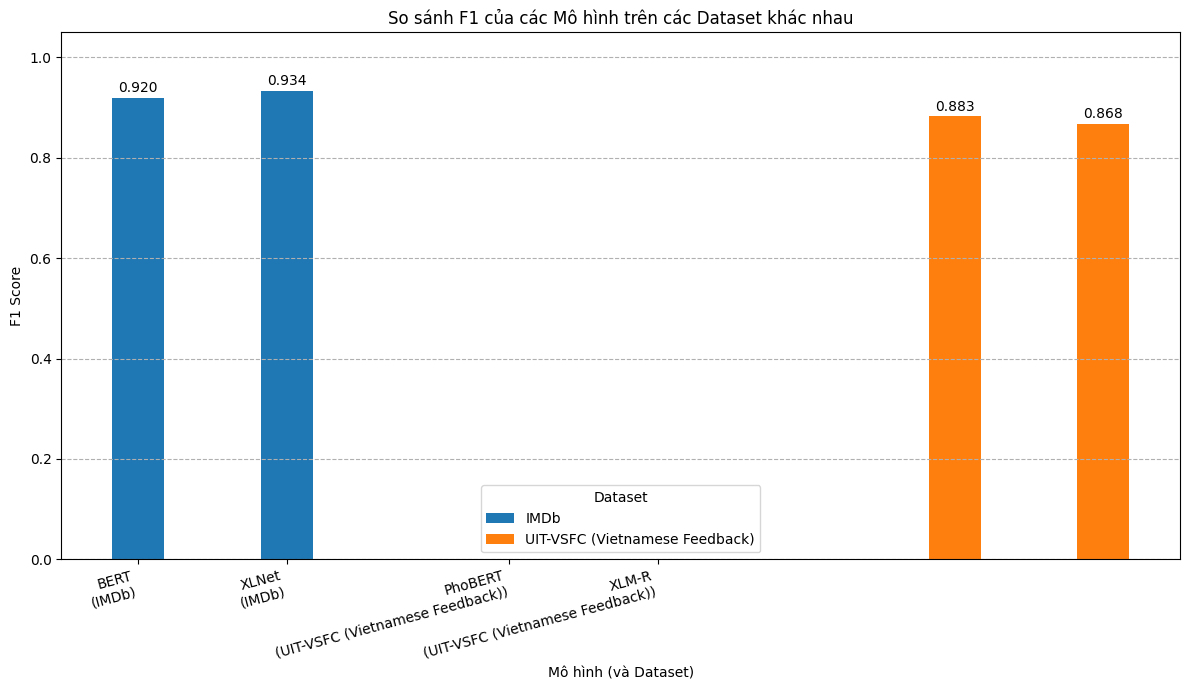

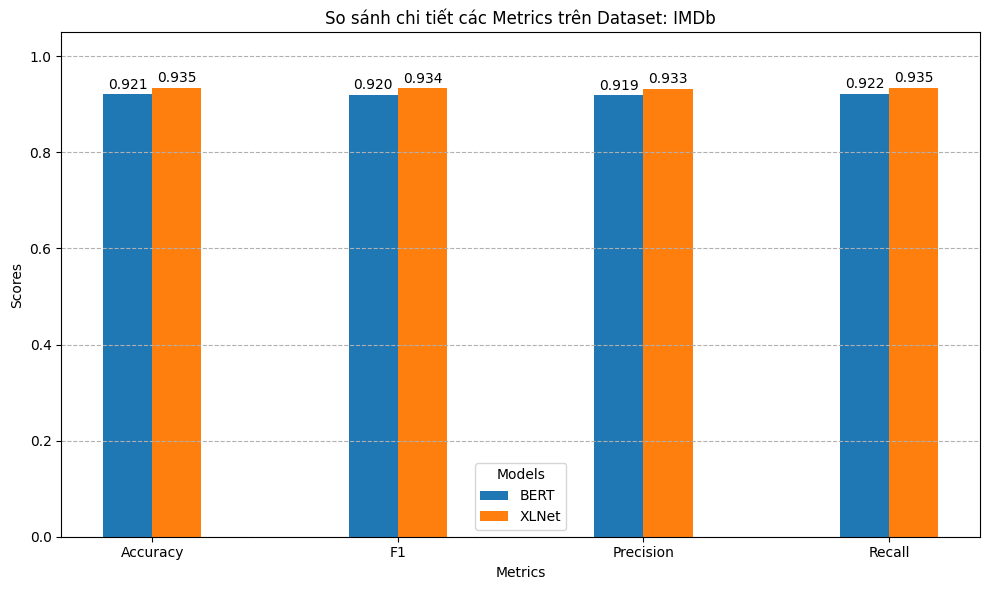

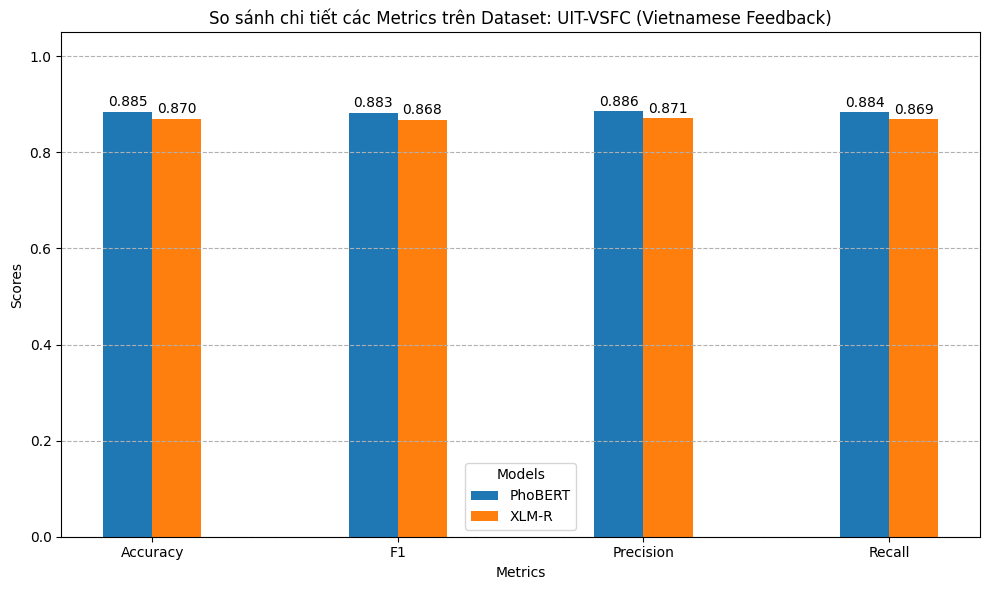

Lưu ý: Để vẽ Confusion Matrix, bạn cần có nhãn dự đoán và nhãn thực tế từ kết quả thử nghiệm.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Dữ liệu kết quả giả định (như trên)
results_data = {
    'IMDb': {
        'BERT': {'accuracy': en_bert_accuracy, 'f1': en_bert_f1, 'precision': en_bert_precision, 'recall': en_bert_recall},
        'XLNet': {'accuracy': en_xlnet_accuracy, 'f1': en_xlnet_f1, 'precision': en_xlnet_precision, 'recall': en_xlnet_recall},
    },
    'UIT-VSFC (Vietnamese Feedback)': {
        'BERT': {'accuracy': vn_bert_accuracy, 'f1': vn_bert_f1, 'precision': vn_bert_precision, 'recall': vn_bert_recall},
        'XLNet': {'accuracy': vn_xlnet_accuracy, 'f1': vn_xlnet_f1, 'precision': vn_xlnet_precision, 'recall': vn_xlnet_recall},
    }
}

# --- Biểu đồ 1: So sánh F1-score của các model trên từng dataset ---
datasets = list(results_data.keys())
metrics_to_plot = ['f1']

for metric_name in metrics_to_plot:
    plt.figure(figsize=(12, 7))
    bar_width = 0.35
    index = 0

    all_model_names = []
    all_scores = []
    all_dataset_names_for_ticks = []

    for i, dataset_name in enumerate(datasets):
        models_in_dataset = list(results_data[dataset_name].keys())
        scores = [results_data[dataset_name][model][metric_name] for model in models_in_dataset]

        x_positions = np.arange(len(models_in_dataset)) + index
        bars = plt.bar(x_positions, scores, bar_width, label=f'{dataset_name}')

        for bar_idx, bar in enumerate(bars):
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.005, f'{yval:.3f}', ha='center', va='bottom')
            all_model_names.append(f"{models_in_dataset[bar_idx]}\n({dataset_name})")
        index += len(models_in_dataset) + 0.5

    plt.xlabel("Mô hình (và Dataset)")
    plt.ylabel(f"{metric_name.capitalize()} Score")
    plt.title(f"So sánh {metric_name.capitalize()} của các Mô hình trên các Dataset khác nhau")

    # Tạo nhãn trục x dựa trên các mô hình và dataset
    tick_positions = []
    current_pos = 0
    for dataset_name in datasets:
        models_in_dataset = list(results_data[dataset_name].keys())
        num_models = len(models_in_dataset)
        tick_positions.extend(np.arange(num_models) + current_pos)
        current_pos += num_models + 0.5


    plt.xticks(tick_positions, all_model_names, rotation=15, ha="right")
    plt.ylim(0, 1.05)
    plt.legend(title="Dataset")
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--')
    plt.show()


# --- Biểu đồ 2: So sánh chi tiết các metrics (Accuracy, F1, Precision, Recall) cho từng dataset ---
for dataset_name, models_data in results_data.items():
    model_names = list(models_data.keys())
    metrics = ['accuracy', 'f1', 'precision', 'recall']
    num_metrics = len(metrics)
    num_models = len(model_names)

    fig, ax = plt.subplots(figsize=(10, 6))
    bar_width = 0.20
    index = np.arange(num_metrics)

    for i, model_name in enumerate(model_names):
        scores = [models_data[model_name][metric] for metric in metrics]
        # Vị trí của các cột cho model hiện tại
        positions = index + i * bar_width
        bars = ax.bar(positions, scores, bar_width, label=model_name)
        for bar in bars:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.005, f'{yval:.3f}', ha='center', va='bottom')


    ax.set_xlabel("Metrics")
    ax.set_ylabel("Scores")
    ax.set_title(f"So sánh chi tiết các Metrics trên Dataset: {dataset_name}")
    ax.set_xticks(index + bar_width * (num_models - 1) / 2)
    ax.set_xticklabels([m.capitalize() for m in metrics])
    ax.legend(title="Models")
    ax.set_ylim(0, 1.05)
    plt.grid(axis='y', linestyle='--')
    plt.tight_layout()
    plt.show()

# --- Biểu đồ 3: Confusion Matrix (Ma trận nhầm lẫn) ---
# Để vẽ ma trận nhầm lẫn, bạn cần có dự đoán thực tế (preds) và nhãn thực tế (labels)
# từ hàm compute_metrics hoặc từ trainer.predict().
# Ví dụ:
from sklearn.metrics import confusion_matrix

# Giả sử bạn có:
# y_true_imdb = [...] # Nhãn thực tế cho một model trên IMDb
# y_pred_imdb = [...] # Nhãn dự đoán cho model đó trên IMDb
# labels_display_imdb = ['Negative', 'Positive'] # Tên các lớp

# y_true_vsfc = [...]
# y_pred_vsfc = [...]
# labels_display_vsfc = ['Negative', 'Neutral', 'Positive'] # Giả sử có 3 lớp cho tiếng Việt

def plot_confusion_matrix(y_true, y_pred, labels_display, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels_display, yticklabels=labels_display)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.show()

# # Gọi hàm này với dữ liệu thực tế của bạn:
# # plot_confusion_matrix(y_true_imdb, y_pred_imdb, labels_display_imdb, "Confusion Matrix - BERT on IMDb")
# # plot_confusion_matrix(y_true_vsfc, y_pred_vsfc, labels_display_vsfc, "Confusion Matrix - PhoBERT on UIT-VSFC")

print("Lưu ý: Để vẽ Confusion Matrix, bạn cần có nhãn dự đoán và nhãn thực tế từ kết quả thử nghiệm.")

# Answer Question:
### Bộ dữ liệu 'uitnlp/vietnamese_students_feedback':
- Số lượng mẫu: ít hơn
- Số label trong 'sentiment': 3
- 
### Bộ dữ liệu 'imdb_dataset':
- Số lượng mẫu: nhiều hơn
- Số label trong 'label': 2


# BÁO CÁO SO SÁNH HIỆU SUẤT MÔ HÌNH NLP VÀ ĐỀ XUẤT CẢI THIỆN

**Ngày:** [Ngày bạn viết báo cáo, ví dụ: 05/06/2025]
**Người báo cáo:** [Tên của bạn]
**Bộ phận:** [Bộ phận của bạn, ví dụ: Phân tích Dữ liệu]

---

## 1. Tóm tắt (Abstract)

Báo cáo này trình bày kết quả so sánh hiệu suất giữa mô hình BERT và XLNet (hoặc các biến thể tương ứng như PhoBERT cho tiếng Việt) trên hai bộ dữ liệu: [Tên bộ dữ liệu tiếng Anh, ví dụ: IMDb] và [Tên bộ dữ liệu tiếng Việt, ví dụ: UIT-VSFC]. Mục tiêu là đánh giá sự khác biệt về hiệu suất và đề xuất các hướng cải thiện cho các phương pháp có kết quả thấp hơn. Kết quả cho thấy [Nêu một phát hiện chính, ví dụ: XLNet vượt trội trên dữ liệu tiếng Anh, trong khi PhoBERT cho kết quả tốt nhất trên dữ liệu tiếng Việt].

## 2. Giới thiệu (Introduction)

* **Mục tiêu:** Đánh giá và so sánh khả năng của các mô hình Transformer (BERT, XLNet) trong tác vụ [Nêu rõ tác vụ, ví dụ: phân loại cảm xúc văn bản] trên các ngôn ngữ và bộ dữ liệu khác nhau.
* **Phạm vi:** Tập trung vào các mô hình [Liệt kê các mô hình cụ thể đã sử dụng] và các bộ dữ liệu [Liệt kê các bộ dữ liệu đã sử dụng]. Các chỉ số đánh giá chính bao gồm [Liệt kê các metrics, ví dụ: Accuracy, F1-score].

## 3. Phương pháp (Methodology)

* **Dữ liệu:**
    * Dataset 1 (Tiếng Anh): [Tên dataset], [Mô tả ngắn, số lượng mẫu, số lớp].
    * Dataset 2 (Tiếng Việt): [Tên dataset], [Mô tả ngắn, số lượng mẫu, số lớp].
    * Tiền xử lý dữ liệu: [Mô tả ngắn gọn các bước tiền xử lý chính].
* **Mô hình:**
    * Mô hình A: [Tên model, ví dụ: bert-base-uncased] - Fine-tuned trên [Dataset].
    * Mô hình B: [Tên model, ví dụ: xlnet-base-cased] - Fine-tuned trên [Dataset].
    * Mô hình C: [Tên model, ví dụ: vinai/phobert-base] - Fine-tuned trên [Dataset].
    * Mô hình D: [Tên model, ví dụ: một biến thể XLNet cho tiếng Việt hoặc XLM-R] - Fine-tuned trên [Dataset].
* **Quá trình thực nghiệm:**
    * Các tham số fine-tuning chính: [Learning rate, batch size, số epochs].
    * Môi trường thực nghiệm: [Phần cứng, thư viện chính sử dụng].
* **Chỉ số đánh giá:** [Accuracy, Precision, Recall, F1-score].

## 4. Kết quả (Results)

* **Bảng tổng hợp kết quả:**

    | Dataset                        | Model   | Accuracy | F1-score | Precision | Recall |
    | :----------------------------- | :------ | :------- | :------- | :-------- | :----- |
    | [Tên Dataset Tiếng Anh]        | BERT    | [Số liệu] | [Số liệu] | [Số liệu]  | [Số liệu] |
    | [Tên Dataset Tiếng Anh]        | XLNet   | [Số liệu] | [Số liệu] | [Số liệu]  | [Số liệu] |
    | [Tên Dataset Tiếng Việt]       | PhoBERT | [Số liệu] | [Số liệu] | [Số liệu]  | [Số liệu] |
    | [Tên Dataset Tiếng Việt]       | [XLNet/XLM-R] | [Số liệu] | [Số liệu] | [Số liệu]  | [Số liệu] |

* **(Tùy chọn) Tham chiếu đến biểu đồ trực quan hóa:** "Chi tiết so sánh trực quan được trình bày trong Phụ lục A hoặc Hình 1, Hình 2..." (nếu bạn có biểu đồ).

## 5. Thảo luận và Phân tích (Discussion & Analysis)

* **So sánh hiệu suất trên dữ liệu tiếng Anh:**
    * [Phân tích sự khác biệt giữa BERT và XLNet, mô hình nào tốt hơn và tại sao (dựa trên kiến trúc, pre-training...)]
* **So sánh hiệu suất trên dữ liệu tiếng Việt:**
    * [Phân tích sự khác biệt giữa PhoBERT và mô hình còn lại, mô hình nào tốt hơn và tại sao (ví dụ: lợi thế của pre-training trên dữ liệu thuần Việt)].
* **Các yếu tố ảnh hưởng:** [Thảo luận về các yếu tố có thể đã ảnh hưởng đến kết quả như chất lượng pre-trained model, đặc điểm dữ liệu, quá trình fine-tuning].

## 6. Đề xuất Cải thiện cho các Phương pháp Yếu hơn (Recommendations)

Dựa trên kết quả và phân tích, các hướng cải thiện tiềm năng bao gồm:

* **Đối với [Mô hình/Dataset cho kết quả yếu hơn]:**
    1.  **Tinh chỉnh siêu tham số (Hyperparameter Tuning):** Thử nghiệm kỹ hơn với learning rate, batch size.
    2.  **Tăng cường dữ liệu (Data Augmentation):** Áp dụng các kỹ thuật như [Nêu cụ thể, ví dụ: back-translation, synonym replacement] để tăng kích thước và sự đa dạng của tập huấn luyện.
    3.  **Lựa chọn Pre-trained Model:** Xem xét các pre-trained model khác phù hợp hơn với đặc thù ngôn ngữ/miền dữ liệu (nếu có).
    4.  **Phân tích lỗi (Error Analysis):** Đi sâu vào các trường hợp mô hình dự đoán sai để hiểu rõ hơn điểm yếu.
    5.  [Các đề xuất khác nếu có, ví dụ: domain-adaptive pre-training].

## 7. Kết luận (Conclusion)

Tóm tắt lại các phát hiện chính về sự khác biệt hiệu suất của các mô hình trên hai bộ dữ liệu. Khẳng định mô hình nào tỏ ra hiệu quả nhất cho từng trường hợp cụ thể trong phạm vi thử nghiệm. Nhấn mạnh tầm quan trọng của việc lựa chọn mô hình phù hợp với ngôn ngữ và dữ liệu, cũng như các chiến lược cải thiện liên tục.

---
**Phụ lục (Nếu có)**
* Phụ lục A: Các biểu đồ trực quan hóa kết quả.
* Phụ lục B: Chi tiết cấu hình thử nghiệm.